In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import warnings
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")


In [37]:
# === Загрузка данных === #
finances = pd.read_csv("../data/finances.csv")
df_train = pd.read_csv('target_train.csv')
df_test = pd.read_csv('target_test.csv')

In [38]:
def linearize_json(data, separator='.', list_brackets=False):
    if isinstance(data, str):
        python_obj = json.loads(data)
    elif hasattr(data, 'read'):
        python_obj = json.load(data)
    else:
        python_obj = data

    result = {}
    def recurse(current, parent_key=''):
        if isinstance(current, dict):
            for key, value in current.items():
                new_key = f"{parent_key}{separator}{key}" if parent_key else key
                recurse(value, new_key)
        elif isinstance(current, list):
            for idx, item in enumerate(current):
                new_key = f"{parent_key}{separator}{idx}" if not list_brackets else f"{parent_key}[{idx}]"
                recurse(item, new_key)
        else:
            if parent_key in result:
                raise ValueError(f"Key {parent_key} already exists")
            result[parent_key] = current

    recurse(python_obj)
    return result

In [39]:
# === JSON парсинг и линеризация === #
finances["inn"] = finances["inn"].apply(int)
lin_finances = pd.DataFrame(list(finances.data.apply(linearize_json)))
lin_finances["inn"] = finances["inn"]

In [40]:
result_df = lin_finances.select_dtypes(exclude="object")

In [41]:
# === Объединение с EGRUL === #
egrul = pd.read_csv("../data/final_egrul.csv")
egrul["inn"] = egrul["inn"].astype(int)
result_df = pd.merge(result_df, egrul, on="inn", how="left").fillna(0)

In [42]:
# === Объединение с ENFORCEMENTS === #
enforcements = pd.read_csv("../data/final_enf.csv")
enforcements["inn"] = enforcements["inn"].astype(int)
result_df = pd.merge(result_df, enforcements, on="inn", how="left").fillna(0)

In [43]:
# === Объединение с train и test === #
df_final_train = pd.merge(df_train, result_df, on='inn', how='left').fillna(0)
df_final_test = pd.merge(df_test, result_df, on='inn', how='left').fillna(0)

df_final_train = df_final_train.dropna()
df_final_test = df_final_test.dropna()

df_final_test

,inn,data.2012.1100.СумОтч,data.2012.1100.СумПрдщ,data.2012.1110.СумОтч,data.2012.1110.СумПрдщ,data.2012.1120.СумОтч,data.2012.1120.СумПрдщ,data.2012.1130.СумОтч,data.2012.1130.СумПрдщ,data.2012.1140.СумОтч,...,egr.Tax_debt_ratio,egr.SupportMSP,egr.UstCap_sum,egr.Reg_years,egr.NedobPost,egr.NelegalFin,egr.MassRuc,egr.MassUchred,enf.SumDolg,enf.OstZadolzh
0,5075011400,2.750240e+09,2.893047e+09,1.890312e+09,1.890286e+09,0.0,0.0,0.0,0.0,0.0,...,0.0909,0,98701900.0,23,0,0,0,0,10000.00,0.00
1,6012008164,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0345,2,30300.0,9,0,0,0,0,12000.84,2000.84
2,7736635059,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0000,2,20000.0,14,0,0,0,0,0.00,0.00
3,7017347363,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0000,2,10000.0,11,0,0,0,0,0.00,0.00
4,5905287704,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0000,7,10000.0,14,0,0,0,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,7825451448,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0000,3,0.0,23,0,0,0,0,0.00,0.00
4496,3243502199,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0000,44,10000.0,14,0,0,0,0,0.00,0.00
4497,5001110206,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0000,7,300000.0,9,0,0,0,0,0.00,0.00
4498,6452085459,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0000,1,10000.0,22,0,0,0,0,0.00,0.00


In [44]:
# === Отбор признаков === #
X = df_final_train.drop(columns=["target", "inn"])
y = df_final_train["target"]

var_thresh = VarianceThreshold(threshold=0.01)
X_filtered = var_thresh.fit_transform(X)
feature_columns = X.columns[var_thresh.get_support()]
X = pd.DataFrame(X_filtered, columns=feature_columns)

In [45]:
# === Масштабирование === #
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [46]:
# === XGBoost === #
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [47]:
# === Оценка === #
y_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
y_val_pred = xgb_model.predict(X_val)

print(classification_report(y_val, y_val_pred))
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Gini Index: {2 * roc_auc - 1:.4f}")

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1567
           1       0.88      0.54      0.67       533

    accuracy                           0.87      2100
   macro avg       0.87      0.76      0.79      2100
weighted avg       0.87      0.87      0.85      2100

ROC AUC: 0.8138
Gini Index: 0.6276


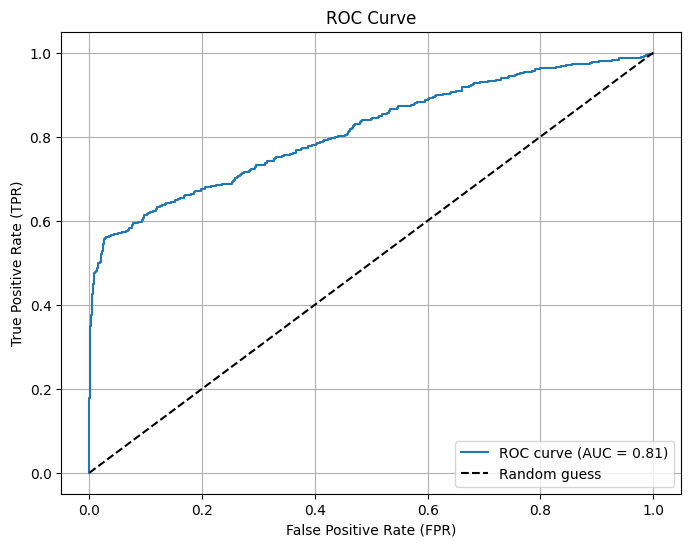

In [48]:
# === ROC-кривая === #

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [49]:
# === Предсказание на тесте === #
X_test_data = df_final_test.drop(columns=["inn"])
X_test_filtered = var_thresh.transform(X_test_data)
X_test_scaled = scaler.transform(X_test_filtered)

test_preds = xgb_model.predict(X_test_scaled)

result = pd.DataFrame({
    "inn": df_final_test["inn"],
    "target": test_preds
})

result.to_csv("to_submit.csv", index=False)

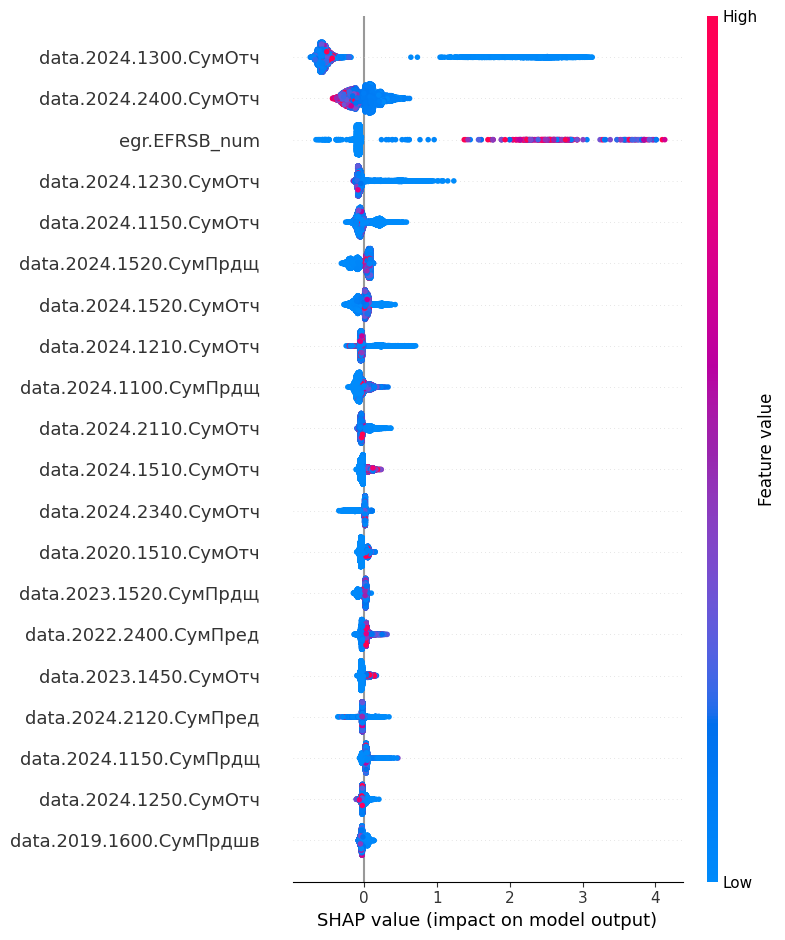

In [50]:
# === Интерпретация результатов === #
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values.values, X_train, feature_names=X.columns)